In [79]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from pexpect import which
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster

from add_legend_svg import font_size


In [80]:
import matplotlib
from matplotlib.font_manager import fontManager
fontManager.addfont('./PingFang Regular.ttf')
#matplotlib.rc('font',family = 'PingFang SC')
matplotlib.rc('font',family = ['Times New Roman','PingFang SC'])

In [81]:
matplotlib.font_manager.get_font_names()

['Noto Sans Syriac',
 'Webdings',
 'Noto Sans Tagalog',
 'Baghdad',
 'Kohinoor Telugu',
 'Noto Sans Old North Arabian',
 'Noto Sans Buginese',
 'Noto Sans Gunjala Gondi',
 'Noto Sans Linear B',
 'Al Tarikh',
 'Noto Serif Yezidi',
 'STIXIntegralsUpSm',
 'Noto Serif Balinese',
 'Noto Sans Cypriot',
 '.SF NS Rounded',
 'STIXSizeFourSym',
 'STIXIntegralsSm',
 '.SF Compact Rounded',
 'Noto Sans Miao',
 'STIXSizeTwoSym',
 '.SF Arabic Rounded',
 'DIN Alternate',
 'Noto Serif Myanmar',
 'Noto Sans Coptic',
 'Noto Sans Caucasian Albanian',
 '.SF Compact',
 'cmex10',
 'Arial Hebrew',
 'Noto Sans Hanifi Rohingya',
 'Noto Sans Khudawadi',
 'Kannada MN',
 'Noto Sans Bhaiksuki',
 'PT Sans',
 'Euphemia UCAS',
 'Noto Sans Modi',
 'Mishafi',
 'Noto Serif Ahom',
 '.Keyboard',
 'Noto Sans Tai Le',
 'Snell Roundhand',
 'Noto Sans PhagsPa',
 'Zapfino',
 'Noto Sans Pau Cin Hau',
 'Diwan Thuluth',
 'Rockwell',
 '.ThonburiUI',
 'Noto Sans Pahawh Hmong',
 'STIXSizeOneSym',
 'Shree Devanagari 714',
 'Futura',
 

In [82]:
# change the path 
path = "../analyzeCodes"
os.chdir(path)


In [83]:
USE_SIMPLE_DATA = False

In [84]:
transfermap = {
    '頂標': 88,
    '前標': 75,
    '均標': 50,
    '後標': 25,
    '底標': 12,
    'nan': 0

}
codeList = ['國文檢定_code','英文檢定_code','數學檢定_code',
            '社會檢定_code','自然檢定_code']
codeList2 = ['國文採計','英文採計','數學採計','社會採計','自然採計']
codeList3 = ['國文倍率','英文倍率','數學倍率','社會倍率','自然倍率']
codeList4 = ['unitier','預定甄試人數','甄試費用','口試佔比','書審佔比']

In [85]:
clusterMapping = {
    1:1,
    2:5,
    3:6,
    4:7,
    5:2,
    6:3,
    7:4,
}

In [86]:
#import data
simpdf = pd.read_csv('./rawData/109_selfapplication_university_cleaned.csv')
rawdf = pd.read_stata('./rawData/109 Selfapplication_V6.dta')

In [87]:
#let the order become same
rawdf['學校名稱_eng_encoded'] = rawdf['學校名稱_eng_encoded'].astype('str')
rawdf.sort_values(by=['學校名稱_eng_encoded','school'], inplace=True)

In [88]:
# clean simp data
label = simpdf.columns
simpdf["id"] = np.arange(0, len(simpdf))
simp_label_df = simpdf[['id', 'university', 'school', 'school_index', 'unitier']]
simpdf = simpdf.drop(['university', 'school', 'id', 'school_index', 'unitier'], axis=1)


In [89]:
#clean raw data
rawdf = rawdf[['學校名稱_code', '學校名稱_encoded', '學系名稱_trim', '學系代碼', '國文檢定_code', '英文檢定_code',
         '數學檢定_code',
         '社會檢定_code', '自然檢定_code', '國文倍率', '英文倍率', '數學倍率', '社會倍率', '自然倍率', '國文採計',
         '英文採計',
         '數學採計', '社會採計', '自然採計', '自設科目組合_code', '自設科目組合倍率', '預定甄試人數',
         '甄試費用', '口試佔比', '書審佔比']]
rawdf['unitier'] = simp_label_df['unitier']


for idx, row in rawdf.iterrows():
    for _ in codeList2:
        rawdf.loc[idx,_] = float(rawdf.loc[idx,_] * rawdf.loc[idx,'自設科目組合倍率'])
    for _ in codeList:
        rawdf[_] = rawdf[_].astype('str')
        rawdf.loc[idx,_] = transfermap[rawdf.loc[idx,_]]

for _ in codeList:
    rawdf[_] = rawdf[_].astype('int')

for col in codeList3:
    rawdf[col] = rawdf[col].apply(lambda x: -np.log10(x) if x != 0 else -np.log10(30))
rawdf['unitier'] = rawdf['unitier'].apply(lambda x: 4-x)

raw_label_df = rawdf[['學校名稱_code', '學校名稱_encoded', '學系名稱_trim', '學系代碼','國文採計',
              '英文採計',
              '數學採計', '社會採計', '自然採計', '自設科目組合_code', '自設科目組合倍率', 'unitier', '預定甄試人數',
              '甄試費用', '口試佔比', '書審佔比']]
rawdf = rawdf.drop(columns = ['學校名稱_code', '學校名稱_encoded', '學系名稱_trim', '學系代碼','國文採計',
                           '英文採計',
                           '數學採計', '社會採計', '自然採計', '自設科目組合_code', '自設科目組合倍率', 'unitier', '預定甄試人數',
                           '甄試費用', '口試佔比', '書審佔比'])

In [90]:
# choose which data to use 
if USE_SIMPLE_DATA:
    data = simpdf
    label_df = simp_label_df
else:
    data = rawdf
    label_df = raw_label_df

In [91]:
# t-SNE Process

# Standardize the data
scaler = StandardScaler()
stddata = scaler.fit_transform(data)

# t-SNE
"""
if USE_SIMPLE_DATA:
    perplexity = 30
else:
    prelexity = 35
"""
    
tsne = TSNE(init = 'pca',
            n_components=2, 
            random_state=0, 
            perplexity=35, 
            max_iter=1000
            )
tsne_data = tsne.fit_transform(stddata)


In [92]:
#linkage cluster
linkage_matrix = linkage(tsne_data, method='average', metric='euclidean')
cluster = fcluster(linkage_matrix,t = 7 , criterion='maxclust')
label_df['cluster'] = cluster


In [93]:
arrar_x = np.array(tsne_data[:,0])
arrar_y = np.array(tsne_data[:,1])

In [94]:
# use sns make scatter plot
#sns.scatterplot(x = arrar_x, y = arrar_y , hue = label_df['cluster'])


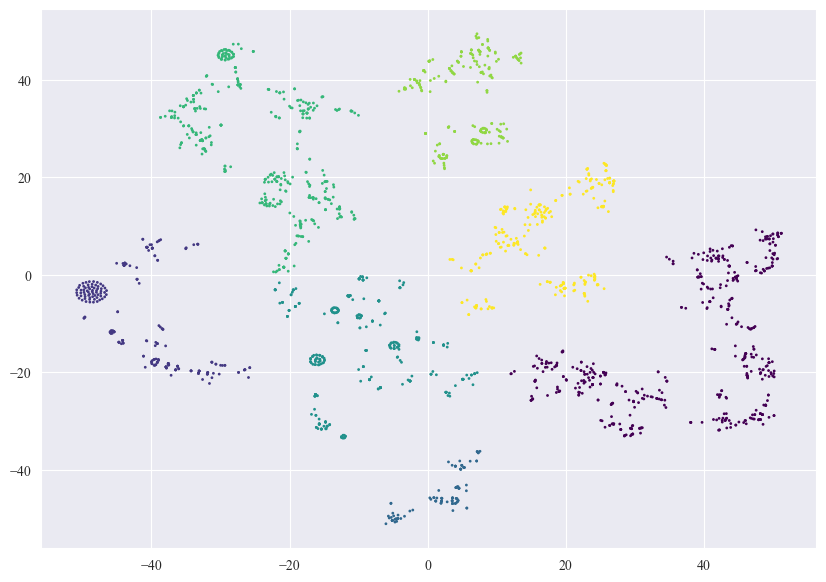

In [95]:
#plot results
plt.figure(figsize=(10, 7))
plt.scatter(arrar_x, arrar_y, c=cluster,s = 1, cmap='viridis')

#plt.savefig(f"./pics/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.png")

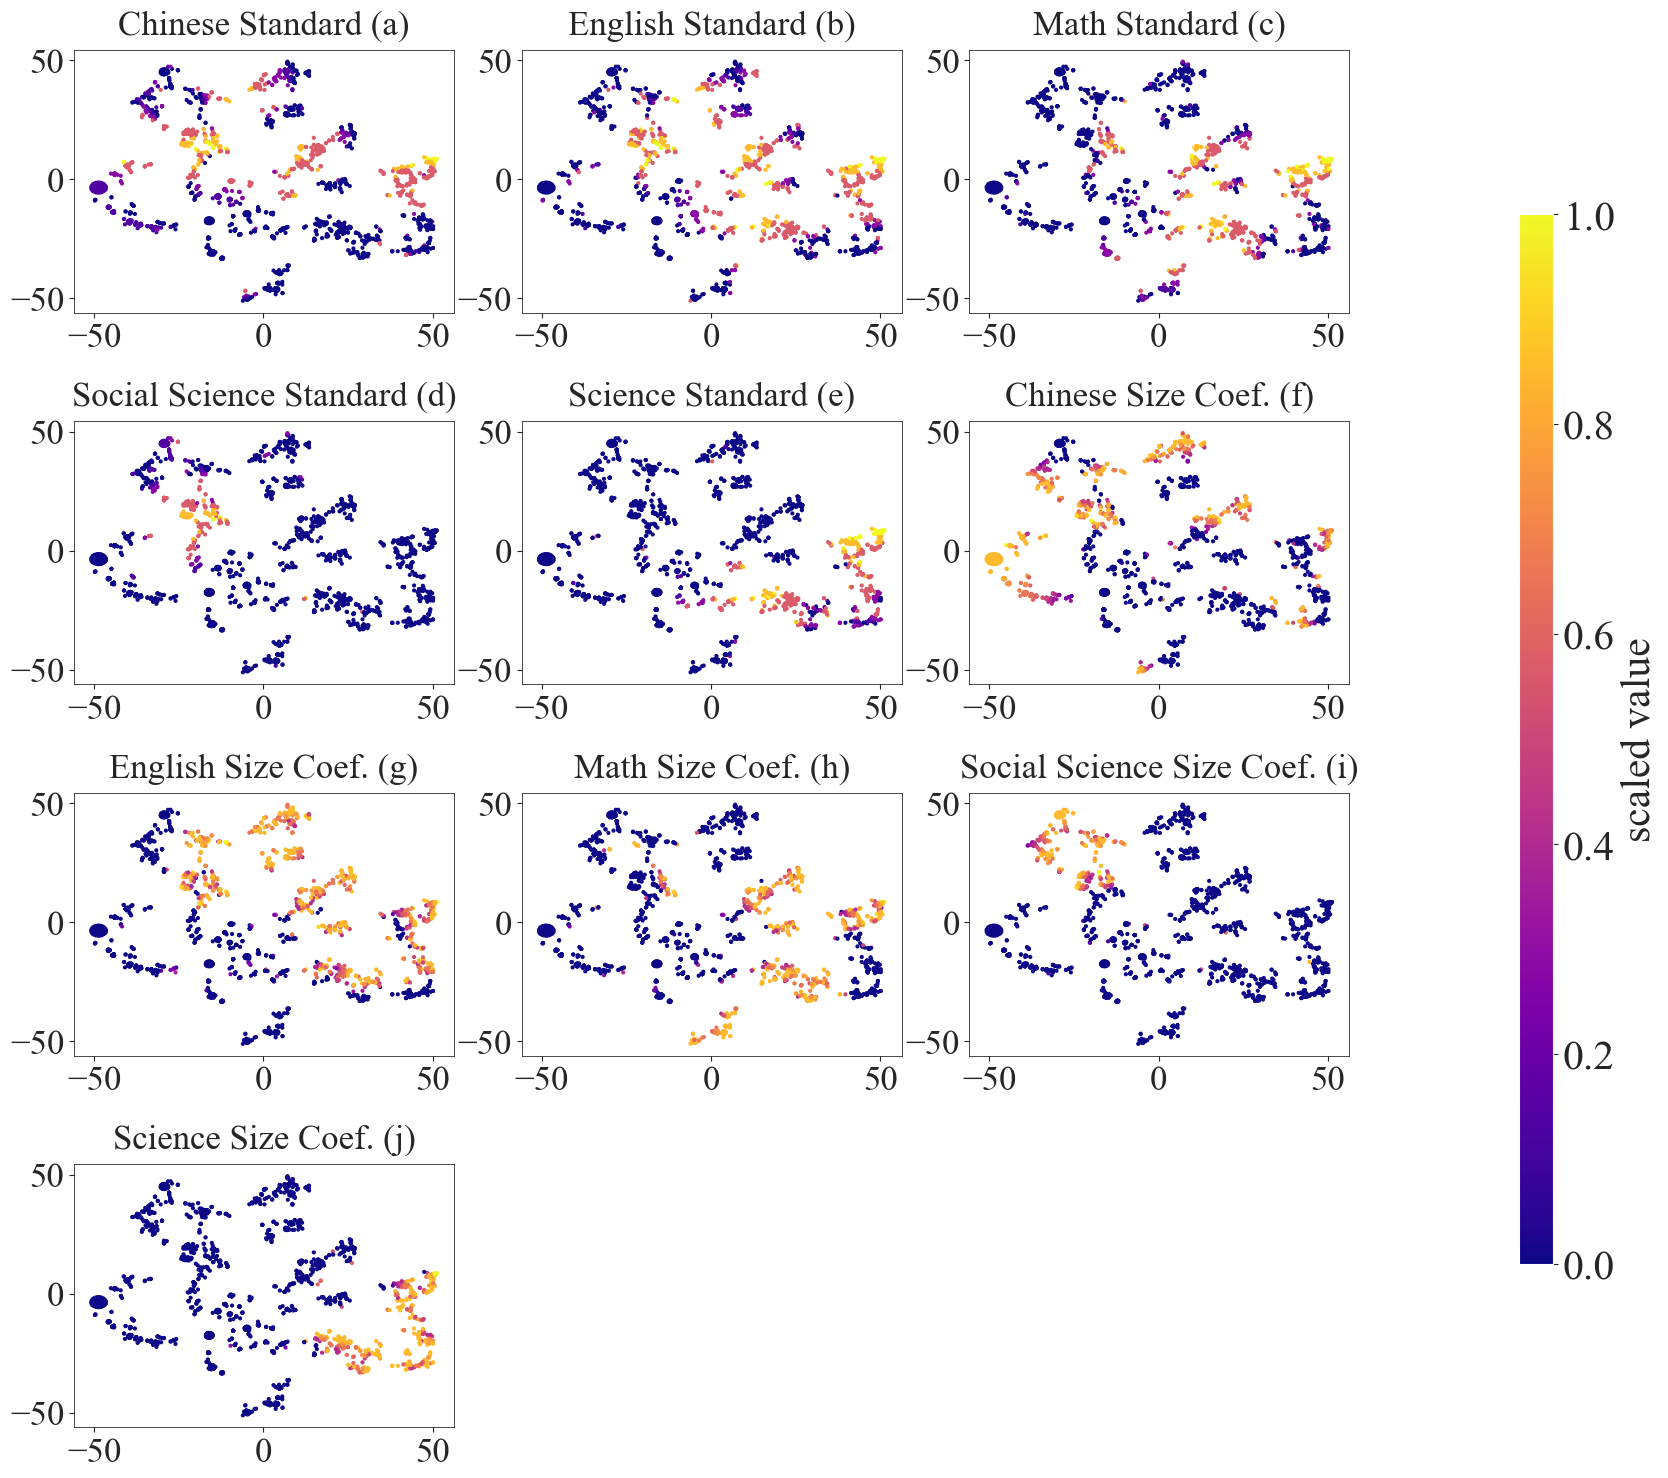

In [96]:
translate_map = {
    '國文檢定_code': 'Chinese Standard (a)',
    '英文檢定_code': 'English Standard (b)',
    '數學檢定_code': 'Math Standard (c)',
    '社會檢定_code': 'Social Science Standard (d)',
    '自然檢定_code': 'Science Standard (e)',
    '國文倍率': 'Chinese Size Coef. (f)',
    '英文倍率': 'English Size Coef. (g)',
    '數學倍率': 'Math Size Coef. (h)',
    '社會倍率': 'Social Science Size Coef. (i)',
    '自然倍率': 'Science Size Coef. (j)'
}


scatter = None
fig,axs = plt.subplots(4,3,sharey=True,sharex=True,figsize=(17,15))
sieve_list = [*codeList,*codeList3]

for idx,sieve in enumerate(sieve_list):
    ax = axs.flat[idx]
    ax.set_facecolor("white")

    # 顯示所有框線
    for spine in ax.spines.values():
        spine.set_visible(True)         # 確保顯示
        spine.set_color('black')        # 邊框顏色
        spine.set_linewidth(0.5)        # 邊框寬度
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', which='major', labelsize=25)

    if idx >= 12:
         continue
    plt.subplot(4,3,idx+1)
    plt.scatter(arrar_x,arrar_y,c = data[sieve],s = 4, cmap='plasma')
    plt.title(f'{translate_map[sieve]}',size = 25,y=1.03)
    plt.grid(False)


for idx in range(len(sieve_list), len(axs.flat)):
    fig.delaxes(axs.flat[idx])

plt.tight_layout(pad = 1.5,h_pad=2.0)
plt.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax,cmap = 'plasma')
cbar.ax.tick_params(labelsize=30)
cbar.set_label('scaled value',fontsize  = 30)


plt.savefig(f"./pics/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster_sieve_distribution.png",dpi = 800)

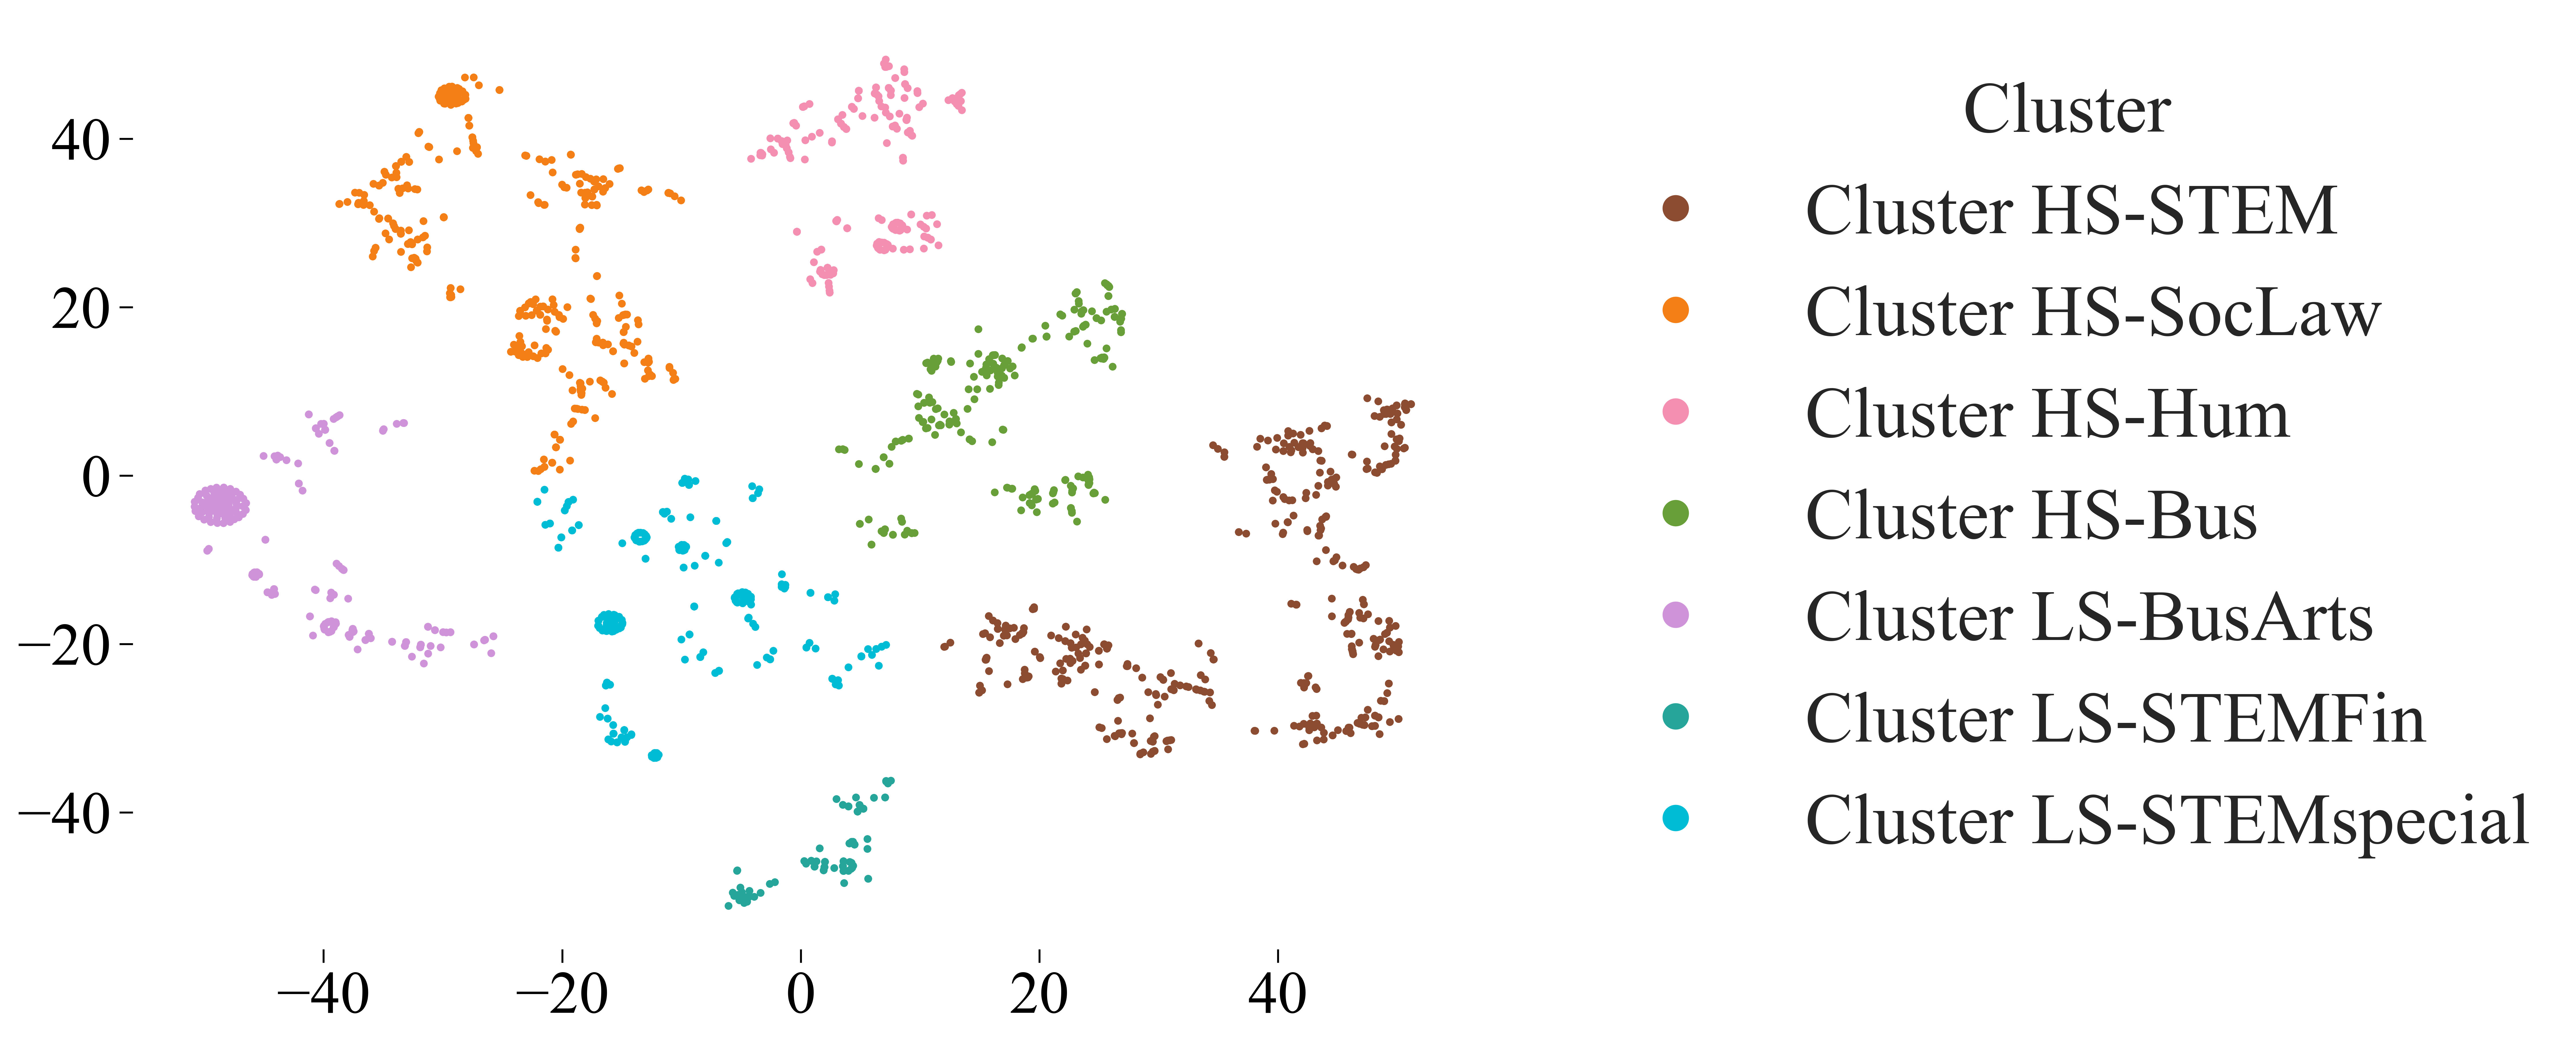

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 假設 cluster 是一個整數 array，例如 array([1,2,3,1,2,...,7])
# 也假設 arrar_x, arrar_y 都已經定義好

# 1. 用剛剛 legend 的 Hex 色碼來對應 cluster
cluster_colors = {
    1: "#8c4c32",
    2: "#ce93d8",
    3: "#26a69a",
    4: "#00bcd4",
    5: "#f57f17",
    6: "#f48fb1",
    7: "#689f38"
}

cluster_code_names = {
    1: "HS-STEM",         # High-score STEM (Science, Life Sciences, Medicine)
    2: "HS-SocLaw",       # High-score Social Sciences and Law (Literature, Society, Education, Law)
    3: "HS-Hum",          # High-score Humanities (Literature and Languages)
    4: "HS-Bus",          # High-score Business (Information Science, Finance, Business)
    5: "LS-BusArts",      # Low-score Business and Arts (Business, Early Education, Management, Arts)
    6: "LS-STEMFin",      # Low-score STEM and Finance (Information Science, Statistics, Finance)
    7: "LS-STEMspecial"   # Low-score STEM with special admissions (Low-score STEM & special tracks)
}


# 2. 定義圖例要顯示的順序（如果需要重排）
order_map = {1:1, 2:5, 3:6, 4:7, 5:2, 6:3, 7:4}
legend_order = [1,5,6,7,2,3,4]  # 按這個順序顯示圖例

# 3. 畫圖
fig, ax = plt.subplots(figsize=(10,7), dpi=600)
fig.patch.set_facecolor('white')
fig.patch.set_linewidth(3.0)
ax.set_facecolor('white')

# 散點圖
point_colors = [cluster_colors[cl] for cl in cluster]
ax.scatter(arrar_x, arrar_y, c=point_colors, s=5)

# 4. 建立 legend elements
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        color=cluster_colors[cl],
        label=f"Cluster {cluster_code_names[order_map[cl]]}",
        markersize=10
    )
    for cl in legend_order
]

ax.legend(
    handles=legend_elements,
    title="Cluster",
    loc='best',
    fontsize=30,
    title_fontsize=30,
    frameon=True,
    edgecolor='white',
    facecolor='white',
    framealpha=0.8,
    bbox_to_anchor = (1.05,1)
)

# 5. 美化軸線與刻度
ax.grid(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(
    axis='both', which='major',
    direction='out', length=6, width=0.8,
    colors='black',labelsize = 25
)

# 6. 儲存並關閉
fig.savefig(
    f"./pics/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.png",
    bbox_inches='tight',
    pad_inches=0,
    dpi=600
)


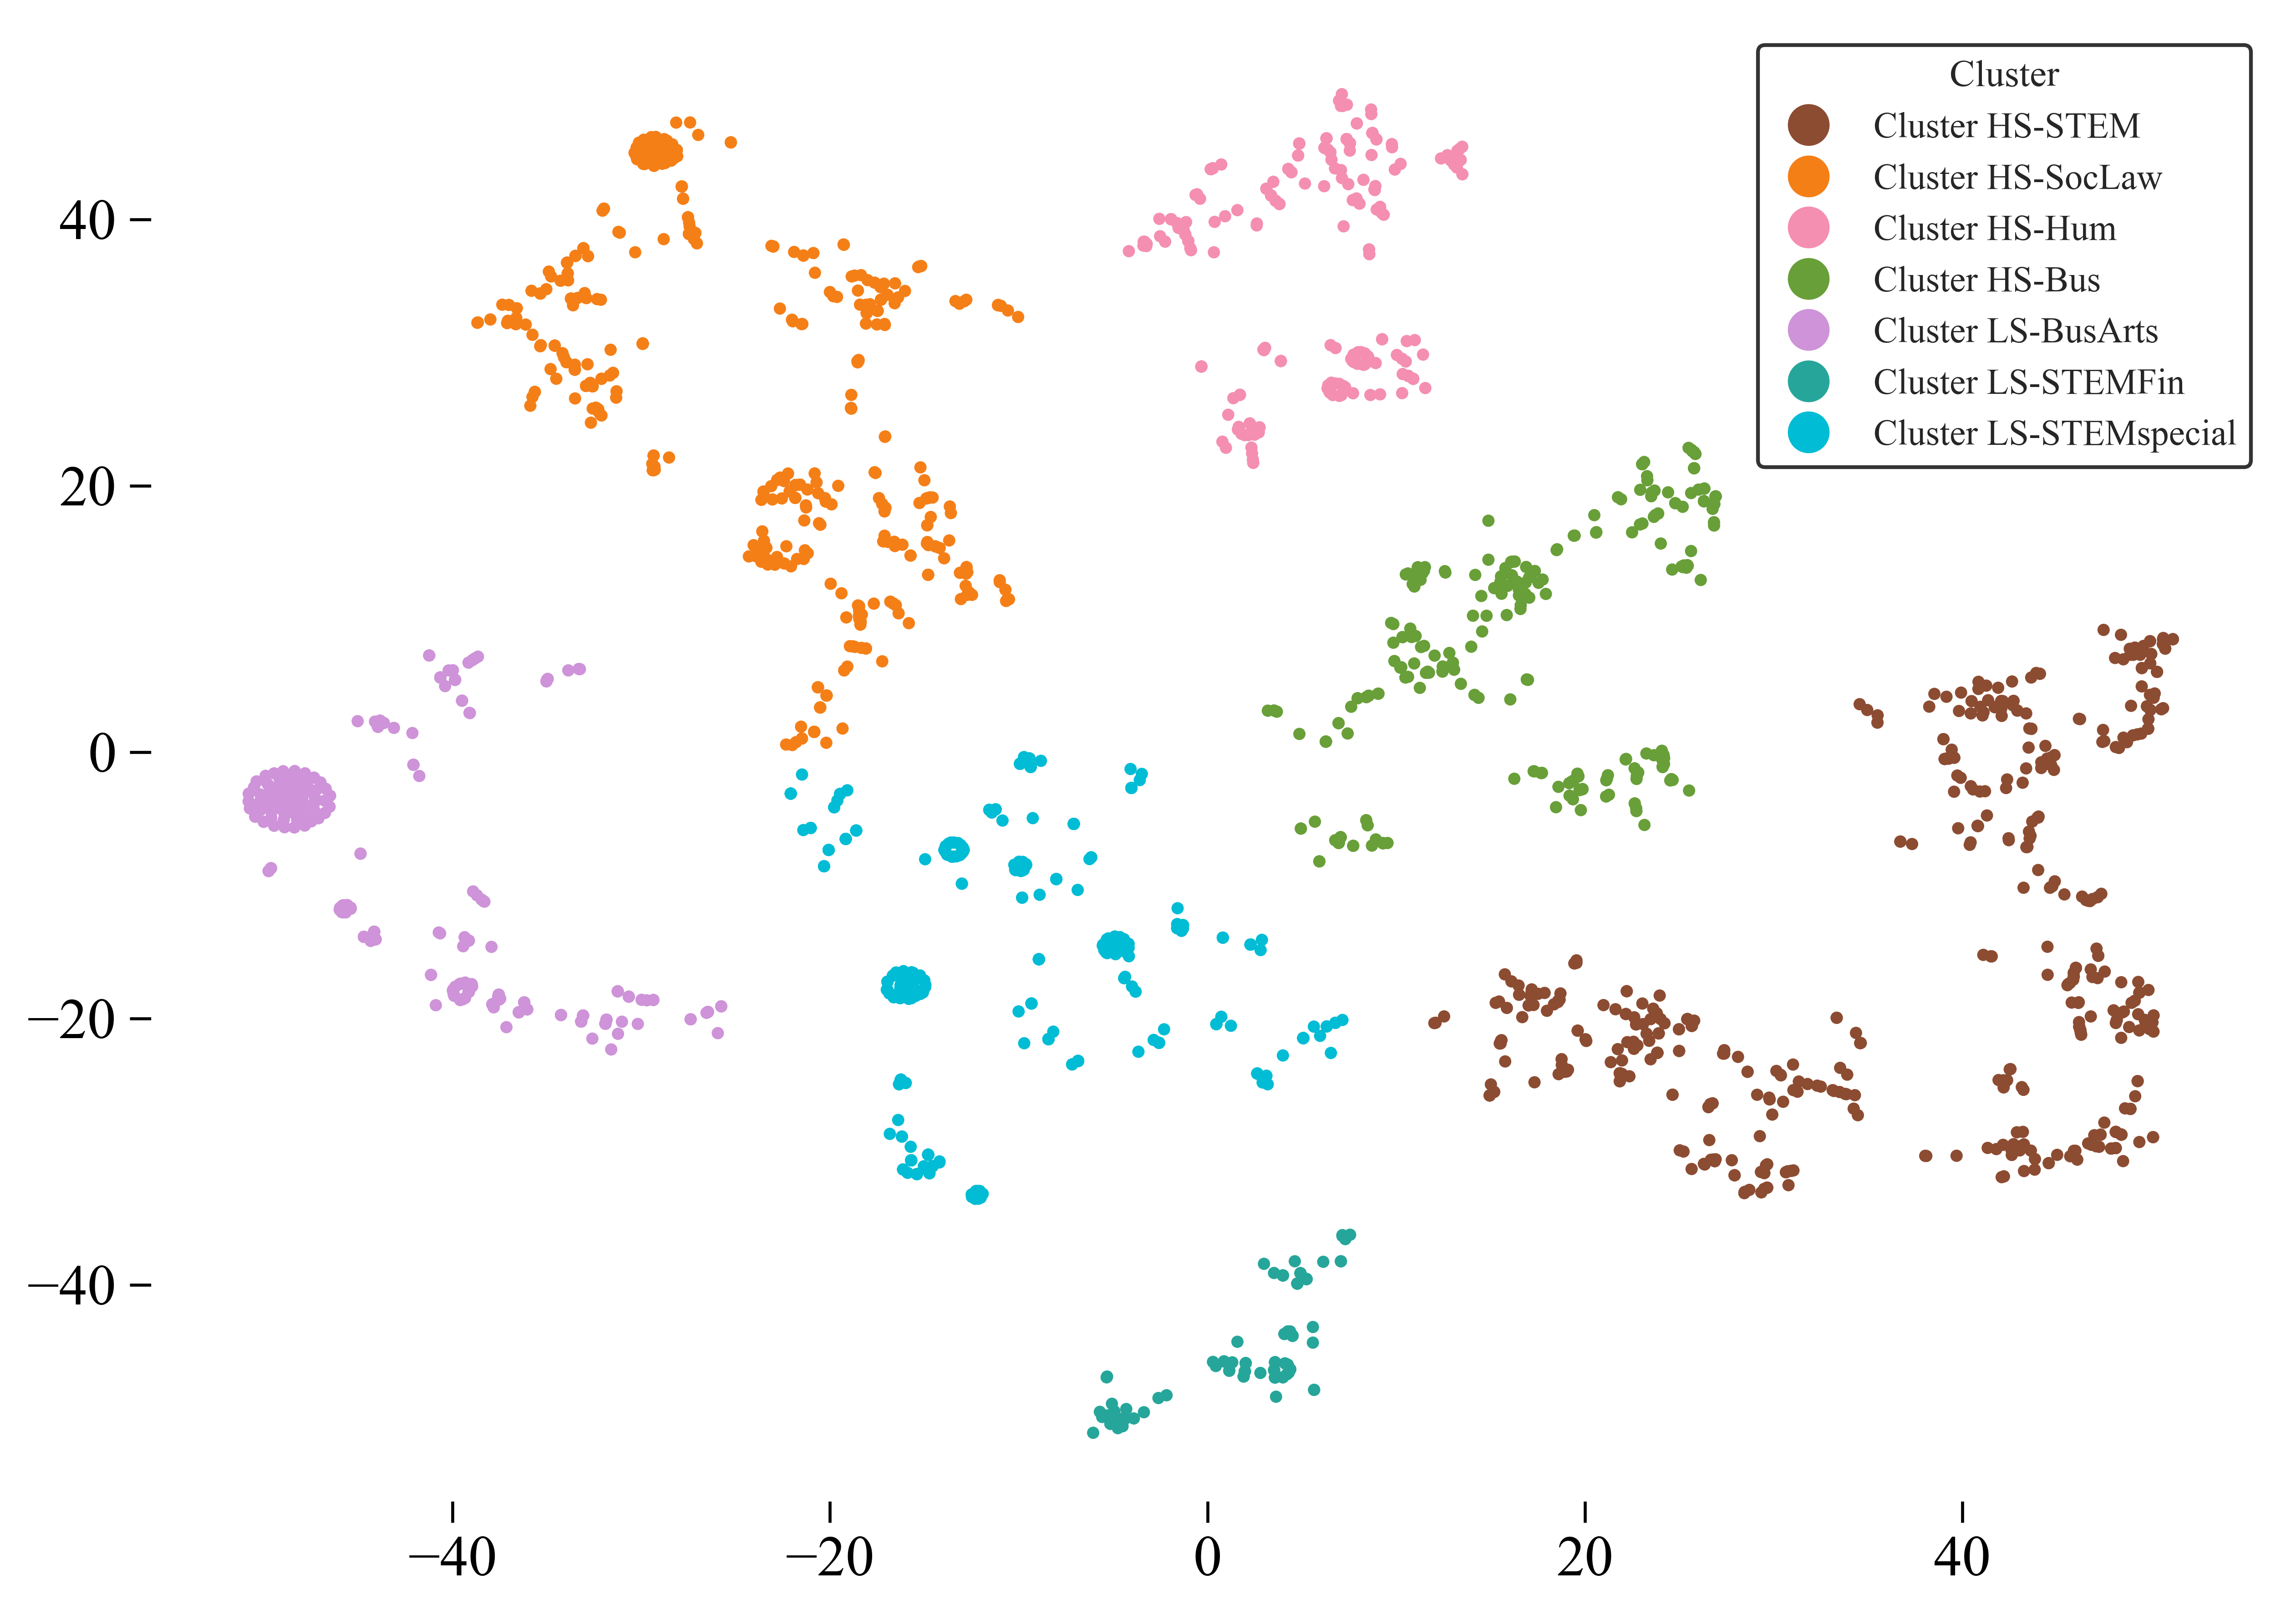

In [98]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# 假設 cluster 是一個整數 array，例如 array([1,2,3,1,2,...,7])
# 也假設 arrar_x, arrar_y 都已經定義好

# 1. 用剛剛 legend 的 Hex 色碼來對應 cluster
cluster_colors = {
    1: "#8c4c32",
    2: "#ce93d8",
    3: "#26a69a",
    4: "#00bcd4",
    5: "#f57f17",
    6: "#f48fb1",
    7: "#689f38"
}

cluster_code_names = {
    1: "HS-STEM",         # High-score STEM (Science, Life Sciences, Medicine)
    2: "HS-SocLaw",       # High-score Social Sciences and Law (Literature, Society, Education, Law)
    3: "HS-Hum",          # High-score Humanities (Literature and Languages)
    4: "HS-Bus",          # High-score Business (Information Science, Finance, Business)
    5: "LS-BusArts",      # Low-score Business and Arts (Business, Early Education, Management, Arts)
    6: "LS-STEMFin",      # Low-score STEM and Finance (Information Science, Statistics, Finance)
    7: "LS-STEMspecial"   # Low-score STEM with special admissions (Low-score STEM & special tracks)
}


# 2. 定義圖例要顯示的順序（如果需要重排）
order_map = {1:1, 2:5, 3:6, 4:7, 5:2, 6:3, 7:4}
legend_order = [1,5,6,7,2,3,4]  # 按這個順序顯示圖例

# 3. 畫圖
fig, ax = plt.subplots(figsize=(10,7), dpi=600)
fig.patch.set_facecolor('white')
fig.patch.set_linewidth(3.0)
ax.set_facecolor('white')

# 散點圖
point_colors = [cluster_colors[cl] for cl in cluster]
ax.scatter(arrar_x, arrar_y, c=point_colors, s=5)

# 4. 建立 legend elements
legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        color=cluster_colors[cl],
        label=f"Cluster {cluster_code_names[order_map[cl]]}",
        markersize=10
    )
    for cl in legend_order
]

ax.legend(
    handles=legend_elements,
    title="Cluster",
    loc='best',
    fontsize=9.5,
    title_fontsize=10,
    frameon=True,
    edgecolor='black',
    facecolor='white',
    framealpha=0.8,
)

# 5. 美化軸線與刻度
ax.grid(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(
    axis='both', which='major',
    direction='out', length=6, width=0.8,
    colors='black',labelsize = 15
)

# 6. 儲存並關閉
fig.savefig(
    f"./pics/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.png",
    bbox_inches='tight',
    pad_inches=0,
    dpi=800
)


1    517
5    425
4    340
7    279
2    248
6    238
3    107
Name: cluster, dtype: int64


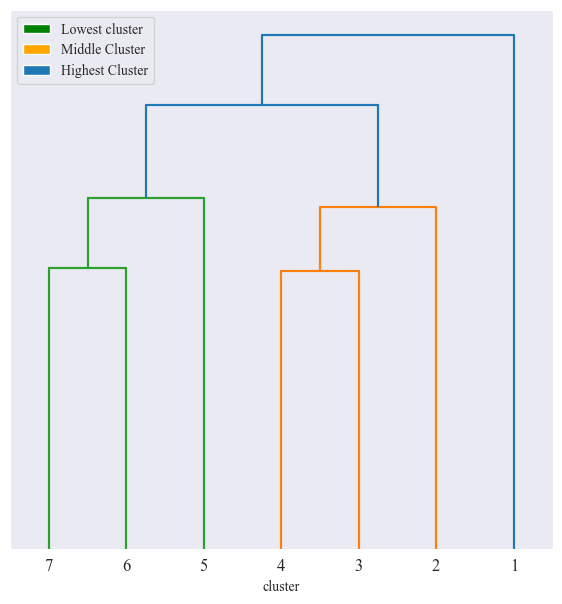

In [99]:
# plot the dendrogram
from scipy.cluster.hierarchy import dendrogram
from matplotlib.patches import Patch
plt.figure(figsize=(7, 7))
Gtemp = dendrogram(linkage_matrix,p=7,truncate_mode='lastp',labels= label_df['cluster'],show_contracted=False,count_sort=True)
def llf(leaf):
    return Gtemp['leaves'].index(leaf)+1
dendrogram(linkage_matrix,
           leaf_label_func=llf,
           p=7,
           truncate_mode='lastp',
           show_contracted=False,
           count_sort=True)
plt.savefig(f"./pics/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster_dendrogram_new.png")
print(label_df['cluster'].value_counts())
plt.gca().xaxis.set_inverted(True)
plt.gca().yaxis.set_tick_params(labelleft=False)
legends = [
    Patch(facecolor='green', 
          label='Lowest cluster'),
    Patch(facecolor='orange', 
          label = "Middle Cluster"),
    Patch(facecolor='C0',
          label= 'Highest Cluster')
]
plt.legend(handles = legends,loc = 'upper left')
plt.xlabel('cluster')
plt.grid(False)
plt.savefig(f"./pics/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster_dendrogram_new_legend.png")

```python
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

# 繪製完整 dendrogram
plt.figure(figsize=(20, 10))  # 放大畫布，否則節點太密會擠在一起

# 自訂 leaf 標籤（這裡顯示 cluster 編號）
def llf(id):
    return f"Clus{label_df['cluster'].iloc[id]}"
dendrogram(
    linkage_matrix,
    p=7,
    leaf_label_func=llf,       # 使用 cluster 資訊當標籤
    show_contracted=False,     # 顯示完整結構（不壓縮）
    count_sort=True,            # 根據群大小排序（可選）
    no_labels=True,
    color_threshold=30,
)

# 圖形美化（可依需要調整）
plt.xticks(rotation=90, fontsize=8)
plt.title("Full Dendrogram of Clusters")
plt.tight_layout()

# 儲存圖檔
#plt.savefig("./pics/full_dendrogram_by_cluster.png")
plt.show()
```


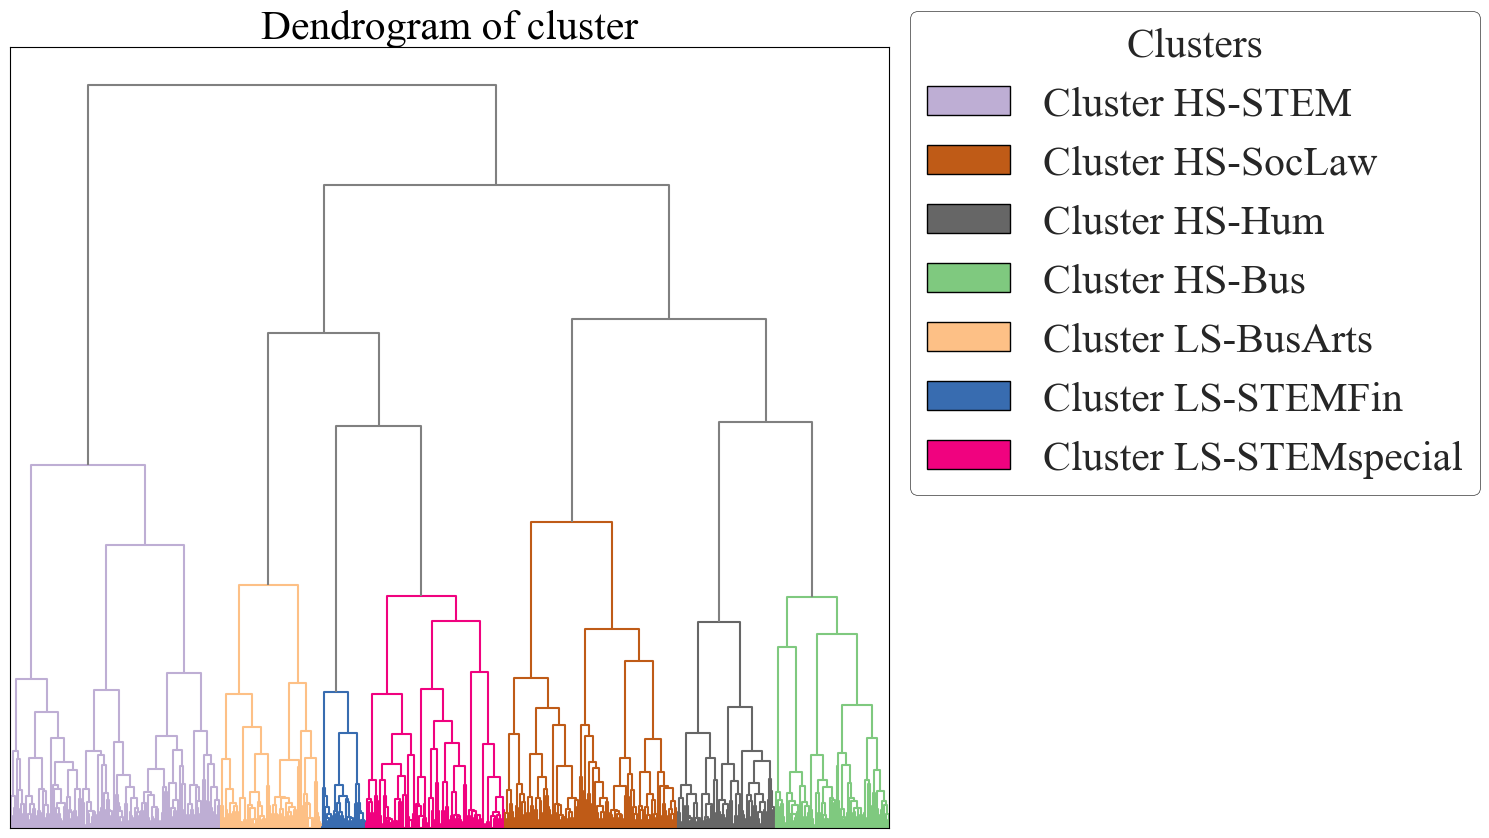

In [100]:

from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
from matplotlib import cycler
from matplotlib.patches import Patch

# 假設你已經有 linkage_matrix、order_map、threshold
threshold = 30
above_col = 'grey'
cluster_code_names = {
    1: "HS-STEM",         # High-score STEM (Science, Life Sciences, Medicine)
    2: "HS-SocLaw",       # High-score Social Sciences and Law (Literature, Society, Education, Law)
    3: "HS-Hum",          # High-score Humanities (Literature and Languages)
    4: "HS-Bus",          # High-score Business (Information Science, Finance, Business)
    5: "LS-BusArts",      # Low-score Business and Arts (Business, Early Education, Management, Arts)
    6: "LS-STEMFin",      # Low-score STEM and Finance (Information Science, Statistics, Finance)
    7: "LS-STEMspecial"   # Low-score STEM with special admissions (Low-score STEM & special tracks)
}

# 1. 建立 7 色的色盤
n_clusters = 7
cmap = plt.get_cmap('Accent', n_clusters)
colors = [cmap(i) for i in range(n_clusters)]
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)

# 2. 新增 fig & ax
fig, ax = plt.subplots(figsize=(15,9))

# 把 figure 背景設成白色、border 設黑線
fig.patch.set_facecolor('white')
fig.patch.set_linewidth(1.0)

# 把坐標軸背景也設成白色
ax.set_facecolor('white')
# 設置四邊黑框
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(0.8)

# 3. 畫 dendrogram
dend = dendrogram(
    linkage_matrix,
    color_threshold=threshold,
    above_threshold_color=above_col,
    no_labels=True,
    ax=ax
)

# 4. 抓出用於 legend 的顏色（剔除 above_threshold_color）
cols = [c for c in dend['color_list'] if c!= above_col]
unique_cols = []
for c in cols:
    if c not in unique_cols:
        unique_cols.append(c)

# 建 handles 時依你想要的 order_map 排序
handles = [
    Patch(facecolor=col, edgecolor='black', label=f"Cluster {cluster_code_names[order_map[i+1]]}")
    for i,col in enumerate(unique_cols)
]
# 如果想換順序，例如先 1，再 5,6,7，再 2,3,4：
handles = [handles[0], *handles[4:7], *handles[1:4]]

# 5. 加 legend，同時把 legend 的背景也設白底黑邊
leg = ax.legend(handles=handles,  loc='lower left',fontsize = 30,bbox_to_anchor = (1, 0.4),title = 'Clusters',title_fontsize = 30)
leg.get_frame().set_facecolor('white')
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(0.5)

# 6. 其他美化
ax.set_title("Dendrogram of cluster", color='black',fontsize =30 )

#ax.tick_params(colors='black',labelsize = 30)    # x,y 軸刻度顏色
ax.tick_params(axis='both',length = 0,labelleft = False)
ax.xaxis.label.set_color('black') # x 軸 label 顏色
ax.yaxis.label.set_color('black')

plt.grid(False)

plt.tight_layout()
plt.savefig('./pics/full_dendrogram_by_cluster.png',dpi = 600)


{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [22.5, 22.5, 52.5, 52.5],
  [5.0, 5.0, 37.5, 37.5]],
 'dcoord': [[0.0, 32.65150188388269, 32.65150188388269, 0.0],
  [0.0, 40.16645208754424, 40.16645208754424, 32.65150188388269],
  [0.0, 32.959133530800486, 32.959133530800486, 0.0],
  [0.0, 41.27505902297752, 41.27505902297752, 32.959133530800486],
  [40.16645208754424, 52.20414116312087, 52.20414116312087, 41.27505902297752],
  [0.0, 60.3320928102, 60.3320928102, 52.20414116312087]],
 'ivl': ['(517)', '(248)', '(107)', '(340)', '(425)', '(238)', '(279)'],
 'leaves': [4300, 4297, 4281, 4296, 4299, 4293, 4295],
 'color_list': ['C1', 'C1', 'C2', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

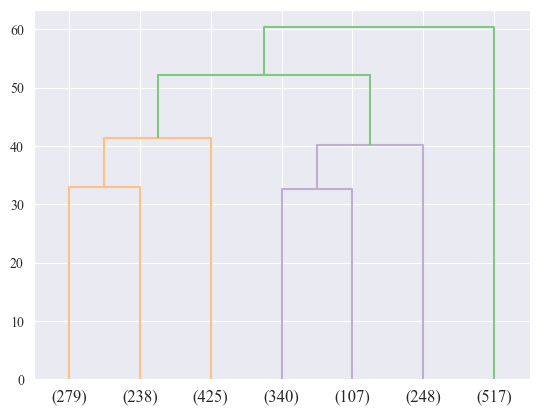

In [101]:
pic = dendrogram(linkage_matrix,p=7,truncate_mode='lastp',labels= label_df['cluster'],show_contracted=False,count_sort=True)
plt.gca().xaxis.set_inverted(True)
pic

In [102]:

Gtemp

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [22.5, 22.5, 52.5, 52.5],
  [5.0, 5.0, 37.5, 37.5]],
 'dcoord': [[0.0, 32.65150188388269, 32.65150188388269, 0.0],
  [0.0, 40.16645208754424, 40.16645208754424, 32.65150188388269],
  [0.0, 32.959133530800486, 32.959133530800486, 0.0],
  [0.0, 41.27505902297752, 41.27505902297752, 32.959133530800486],
  [40.16645208754424, 52.20414116312087, 52.20414116312087, 41.27505902297752],
  [0.0, 60.3320928102, 60.3320928102, 52.20414116312087]],
 'ivl': ['(517)', '(248)', '(107)', '(340)', '(425)', '(238)', '(279)'],
 'leaves': [4300, 4297, 4281, 4296, 4299, 4293, 4295],
 'color_list': ['C1', 'C1', 'C2', 'C2', 'C0', 'C0'],
 'leaves_color_list': ['C0', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2']}

In [103]:
# save results
if USE_SIMPLE_DATA:
    data = rawdf
    label_df = raw_label_df
    label_df['cluster'] = cluster

for col in codeList3:
    data[col] = data[col].apply(lambda x: 10**(-x))
data['tsnepos1'] = tsne_data[:,0]
data['tsnepos2'] = tsne_data[:,1]
data = pd.concat([data, label_df], axis=1)

In [104]:
# transfer to the cluster sort by the relative sieve standard
data['cluster'] = data['cluster'].apply(lambda x: clusterMapping[x])
data.to_csv(f"./processedData/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.csv")

In [105]:
data.groupby('cluster').mean()

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_13864/483206147.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data.groupby('cluster').mean()


,國文檢定_code,英文檢定_code,數學檢定_code,社會檢定_code,自然檢定_code,國文倍率,英文倍率,數學倍率,社會倍率,自然倍率,...,數學採計,社會採計,自然採計,自設科目組合_code,自設科目組合倍率,unitier,預定甄試人數,甄試費用,口試佔比,書審佔比
cluster,,,,,,,,,,,,,,,,,,,,,
1,20.851064,39.582205,40.533849,0.435203,48.508704,23.890716,12.390716,13.098646,29.905222,5.323985,...,1.484043,0.017408,1.641335,19.458414,1.197292,1.735010,82.673114,1039.458414,0.256093,0.285667
2,33.371765,29.505882,11.112941,30.910588,0.235294,13.235294,16.969412,26.656471,9.396471,29.943529,...,0.480588,0.896471,0.007059,20.397647,0.838824,1.884706,72.343529,980.729412,0.391882,0.258118
3,16.264706,26.348739,0.827731,0.882353,0.462185,14.913866,3.869748,29.903361,30.000000,30.000000,...,0.382353,0.218487,0.000000,21.084034,0.703782,1.810924,95.567227,934.327731,0.373403,0.244244
4,32.960573,44.491039,42.870968,0.000000,5.512545,17.501792,8.046595,8.756272,29.913978,29.433692,...,1.742294,0.320789,0.364695,18.354839,1.356631,1.820789,83.537634,1079.211470,0.282975,0.285842
5,16.923387,1.951613,0.346774,1.399194,0.399194,5.010081,29.375000,29.685484,29.959677,30.000000,...,0.399194,0.247984,0.076613,22.495968,0.459677,1.846774,84.314516,766.250000,0.462500,0.288911
6,2.196262,4.906542,25.000000,0.112150,0.700935,24.163551,30.000000,3.658879,30.000000,30.000000,...,1.060748,0.102804,0.154206,21.897196,0.579439,1.925234,96.056075,885.327103,0.402336,0.269159
7,7.385294,14.023529,12.579412,2.258824,8.888235,29.705882,29.419118,29.454412,29.744118,29.861765,...,2.861765,1.158824,1.257353,12.158824,3.094118,1.850000,104.532353,937.529412,0.266029,0.333235


# Analysis the results of t-SNE 

1. show the different 
2. do some test
3. output the results by latex table
4. show the elbow of cluster

In [30]:
# import data
print("Use simple data = ",USE_SIMPLE_DATA)
data = pd.read_csv(f"./processedData/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.csv")

Use simple data =  False


In [31]:
# the statistics of cluster attrs

try:
    dataNoName = data.drop(columns = ['學校名稱_encoded','學系名稱_trim','學系代碼','Unnamed: 0'])
except:
    dataNoName = data.drop(columns = ['學校名稱_encoded','學系名稱_trim','學系代碼'])
attrsByCluster = dataNoName.groupby('cluster').agg(['mean','std','count'])


In [32]:
# test the mean of different cluster is equal or not, first test nomalty
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import kruskal

for col in dataNoName.columns:
    tval = True
    for subcol in [dataNoName[dataNoName['cluster'] == cls][col] for cls in range(1,8)]:
        if shapiro(subcol)[1] < 0.05:
            tval = False
            break
    if tval > 0.05:
        #print(f"{col} is normal")
        print(f"{col} : F-statistic is {f_oneway(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[0] :.3f}, p-vlaue is {f_oneway(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] :.3f}. \n the different of each group is {'signifact' if kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] < 0.05 else 'not signifact'}")
    else:
        #print(f"{col} is not normal")
        print(f"{col} : Kruskal statistic is {kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[0] :.3f}, p-vlaue is {kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] :.3f}.\n the different of each group is  {'signifact' if kruskal(*[dataNoName[col][dataNoName['cluster'] == i] for i in range(1,8)])[1] < 0.05 else 'not signifact'}")


國文檢定_code : Kruskal statistic is 313.243, p-vlaue is 0.000.
 the different of each group is  signifact
英文檢定_code : Kruskal statistic is 539.259, p-vlaue is 0.000.
 the different of each group is  signifact
數學檢定_code : Kruskal statistic is 836.099, p-vlaue is 0.000.
 the different of each group is  signifact
社會檢定_code : Kruskal statistic is 1239.053, p-vlaue is 0.000.
 the different of each group is  signifact
自然檢定_code : Kruskal statistic is 1496.418, p-vlaue is 0.000.
 the different of each group is  signifact
國文倍率 : Kruskal statistic is 739.471, p-vlaue is 0.000.
 the different of each group is  signifact
英文倍率 : Kruskal statistic is 1043.830, p-vlaue is 0.000.
 the different of each group is  signifact
數學倍率 : Kruskal statistic is 1181.406, p-vlaue is 0.000.
 the different of each group is  signifact
社會倍率 : Kruskal statistic is 1631.566, p-vlaue is 0.000.
 the different of each group is  signifact
自然倍率 : Kruskal statistic is 1962.044, p-vlaue is 0.000.
 the different of each group is 

/Users/eric/Documents/SchoolCourses/schoolNetworkGithub/analyzeCodes/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: Input data has range zero. The results may not be accurate.
  res = hypotest_fun_out(*samples, **kwds)
/Users/eric/Documents/SchoolCourses/schoolNetworkGithub/analyzeCodes/.venv/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [33]:
# output the results by latex table
attrsByCluster.to_latex(f"./results/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.tex")

/var/folders/n9/jhsz5r6d6cvctky31mq3pnfr0000gn/T/ipykernel_48531/4280108233.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  attrsByCluster.to_latex(f"./results/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.tex")


In [34]:
# output results csv by .png
attrsByCluster.to_csv(f"./results/{'simplify_' if USE_SIMPLE_DATA else 'raw_'}tsneCluster.csv")

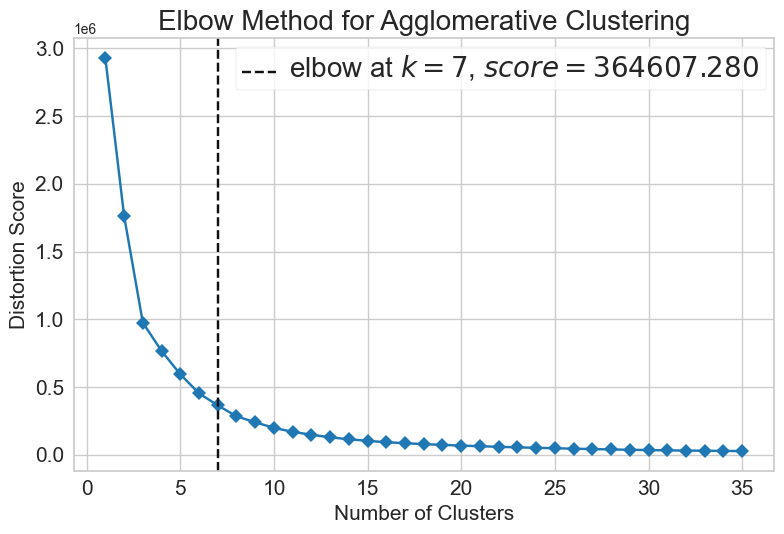

In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from yellowbrick.cluster import KElbowVisualizer

model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(1, 36), timings=False, color={0: 'blue'})

# Fit the visualizer
visualizer.fit(tsne_data)

# 強制 finalize（畫出圖）
visualizer.finalize()

# 修改標題、標籤與刻度字體大小
visualizer.ax.lines[0].set_color("tab:blue")
visualizer.ax.set_title("Elbow Method for Agglomerative Clustering", fontsize=20)
visualizer.ax.set_xlabel("Number of Clusters", fontsize=15)
visualizer.ax.set_ylabel("Distortion Score", fontsize=15)
visualizer.ax.tick_params(axis='both', labelsize=15)
legend = visualizer.ax.get_legend()
if legend:
    for text in legend.get_texts():
        text.set_fontsize(20)

# 另存圖檔
plt.tight_layout()
plt.savefig("./pics/elbow_method.png", dpi=600)
plt.show()
